In [2]:
! pip install geopandas

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 69.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 61.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 55.8 MB/s eta 0:00:00a 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [6]:
! pip install geodatasets

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 kB 6.8 MB/s eta 0:00:00


IR
100 interventions
R Counts: [ 92306 128685  41456  45525   1512   2857   5308]
Null counts: [24104.37975239 32107.481804   13839.97173487 18326.38619879
   539.25388099   770.21819621  1602.87722389]
Post counts: [24528.81506365 32185.92837982 13898.30443638 18345.00666464
   540.11933666   810.73290379  1581.26068529]
Total students: 91890.16747023091
Total percentage increase in outcome: 0.6568024353689601
Null rates: [0.26113557 0.24950446 0.33384725 0.40255653 0.35664939 0.26958985
 0.30197386]
Post rates: [0.2657337  0.25011406 0.33525435 0.40296555 0.35722178 0.2837707
 0.29790141]
Percentage change: [ 1.76  0.24  0.42  0.1   0.16  5.26 -1.35]
Null disparity gap: 1.4288825318573966
Post disparity gap: 1.386028536305324
IR + 'no harm'
100 interventions
R Counts: [ 92306 128685  41456  45525   1512   2857   5308]
Null counts: [24104.37975239 32107.481804   13839.97173487 18326.38619879
   539.25388099   770.21819621  1602.87722389]
Post counts: [24533.88177112 32281.62105578 139

/tmp/ipykernel_784/399924360.py:281: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.pointplot(
/tmp/ipykernel_784/399924360.py:281: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.pointplot(
/tmp/ipykernel_784/399924360.py:281: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.pointplot(
/tmp/ipykernel_784/399924360.py:281: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.pointplot(


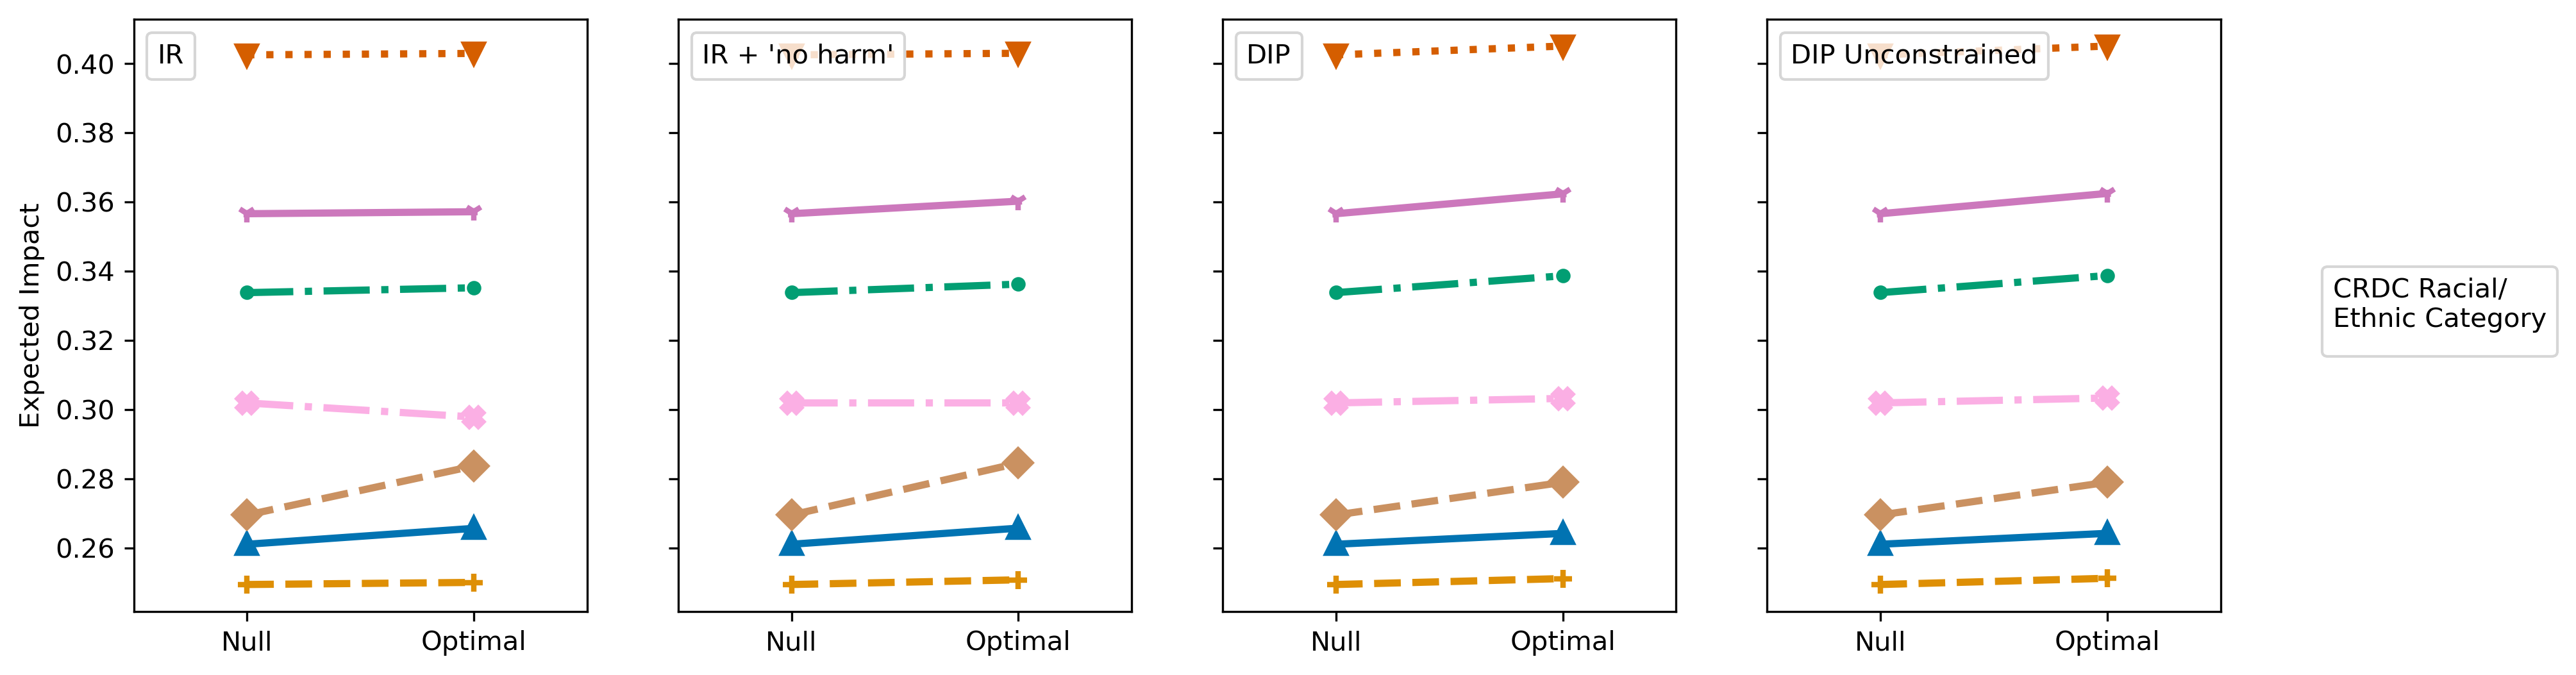

None                [0.00 0.00 0.00 0.00 0.00 0.00 0.00]	91290.569	0	1.429
IR                  [1.76 0.24 0.42 0.10 0.16 5.26 -1.35]	91890.167	0.657	1.386
IR + 'no harm'      [1.78 0.54 0.74 0.11 1.02 5.56 0.00]	92064.934	0.848	1.394
DIP                 [1.20 0.69 1.46 0.63 1.61 3.50 0.43]	92160.912	0.953	1.435
DIP Unconstrained   [1.21 0.72 1.48 0.63 1.64 3.51 0.47]	92176.564	0.971	1.435



In [3]:
from itertools import product, combinations

import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

SOCIAL_CATEGORIES = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
PARAM_NAME = '7_disagg'

count_columns = [f'n_{category}' for category in SOCIAL_CATEGORIES]
frac_columns = [f'frac_{category}' for category in SOCIAL_CATEGORIES]
y_frac_columns = [f'frac_sat_act_{category}' for category in SOCIAL_CATEGORIES]
y_count_columns = [f'n_sat_act_{category}' for category in SOCIAL_CATEGORIES]
X_columns = ['frpl_rate', 'calculus', 'ap_ib', 'counselors']

df = pd.read_csv('features.csv')

X = df[X_columns]
n = len(X)
neighbor_distance_matrix = np.load('neighbor_distance_matrix.npy')
Li = X['frpl_rate'].values.reshape(n, 1)
Li = np.ones_like(Li)
A_frac = df[frac_columns].values

calculus = X['calculus'].values
max_Sij_Cj = np.max(neighbor_distance_matrix * calculus.T,
                    axis=1).reshape(n, 1)
a_Li_max_Sij_Cj = A_frac * Li * max_Sij_Cj

ap_ib = X['ap_ib'].values
max_Sij_Pj = np.max(neighbor_distance_matrix * ap_ib.T,
                    axis=1).reshape(n, 1)
a_Li_max_Sij_Pj = A_frac * Li * max_Sij_Pj

counselors = X['counselors'].values
a_Li_Fi = A_frac * Li * counselors.reshape(n, 1)

a_Li = A_frac * Li

X_train = np.concatenate((
    a_Li_max_Sij_Cj,
    a_Li_max_Sij_Pj,
    a_Li_Fi,
    a_Li
), axis=1)

y_train = df[y_frac_columns].values

linmod = LinearRegression(fit_intercept=False).fit(X_train, y_train)
model_weights = linmod.coef_

column_names = [
    f'{param}_{category}'
    for param in ['alpha', 'beta', 'gamma', 'theta']
    for category in SOCIAL_CATEGORIES
]
row_names = SOCIAL_CATEGORIES
weight_df = pd.DataFrame(model_weights, columns=column_names)
weight_df.index = row_names
WEIGHT_MATRIX = weight_df.values
NUM_SCHOOLS = X.shape[0]
AP_IB = X['ap_ib'].values
COUNSELORS = X['counselors'].values
FRPL = np.ones_like(X['frpl_rate'].values)
R_FRAC = df[frac_columns]
R_MATRIX = R_FRAC.values
NEIGHBOR_INDEX_MATRIX = np.load('neighbor_index_matrix.npy')
NEIGHBOR_DISTANCE_MATRIX = np.load('neighbor_distance_matrix.npy')
NUM_NEIGHBORS = NEIGHBOR_INDEX_MATRIX.shape[1]
NUM_CATEGORIES = WEIGHT_MATRIX.shape[0]
CATEGORIES = list(range(NUM_CATEGORIES))
CATEGORY_PAIRS = list(combinations(CATEGORIES, 2))
TOTAL_STUDENTS = df['total_students'].values
R_COUNTS = df[count_columns].values
R_COUNTS_TOTAL = R_COUNTS.sum(axis=0)

CALCULUS = X['calculus']
WHETHER_OR_NOT_CALCULUS_GIVEN_INTERFERENCE = np.max(
        NEIGHBOR_DISTANCE_MATRIX * CALCULUS.values, axis=1)

df = pd.read_csv('features.csv')

X = df[X_columns]
n = len(X)
neighbor_distance_matrix = np.load('neighbor_distance_matrix.npy')

A_frac = df[frac_columns]

ap_ib = X['ap_ib'].values
max_Sij_Pj = np.max(neighbor_distance_matrix * ap_ib.T,
                    axis=1).reshape(n, 1)
a_max_Sij_Pj = A_frac * max_Sij_Pj

calculus = X['calculus'].values
max_Sij_Cj = np.max(neighbor_distance_matrix * calculus.T,
                    axis=1).reshape(n, 1)
a_max_Sij_Cj = A_frac * max_Sij_Cj

counselors = X['counselors'].values
a_Fj = A_frac * counselors.reshape(n, 1)

a = A_frac

X_train = np.concatenate((
    a_max_Sij_Pj,
    a_max_Sij_Cj,
    a_Fj,
    a
), axis=1)
y_train = df['frac_sat_act'].values

linmod = LinearRegression(fit_intercept=False).fit(X_train, y_train)
model_weights = linmod.coef_
param_dims = len(SOCIAL_CATEGORIES)
weight_dict = {
    'alpha': model_weights[param_dims:param_dims*2],
    'beta': model_weights[:param_dims],
    'gamma': model_weights[param_dims*2:param_dims*3],
    'theta': model_weights[-param_dims:],
}

params = pd.DataFrame(weight_dict)

ALPHA, BETA, GAMMA, THETA = (params['alpha'].values, params['beta'].values, 
                             params['gamma'].values, params['theta'].values)


def expected_disagg_impact_i(index, intervention_array, a):
    nearest_neighbor_indices = NEIGHBOR_INDEX_MATRIX[index, :]
    neighbor_distances = NEIGHBOR_DISTANCE_MATRIX[index,
                                                  nearest_neighbor_indices]

    calculus_value = a * max(
        WHETHER_OR_NOT_CALCULUS_GIVEN_INTERFERENCE[index], 
        np.max(neighbor_distances * intervention_array)
    )

    ap_ib_value = a * np.max(
        neighbor_distances * AP_IB[nearest_neighbor_indices]
    )

    counselors_value = a * COUNSELORS[index]
    frpl_value = a
    r_frac = R_FRAC.iloc[index].values
    calculus_value *= r_frac
    ap_ib_value *= r_frac
    counselors_value *= r_frac
    frpl_value *= r_frac

    vector = np.concatenate((
        calculus_value,
        ap_ib_value,
        counselors_value,
        frpl_value
    ), axis=0)

    impact = np.matmul(WEIGHT_MATRIX, vector)

    for i in range(len(impact)):
        impact[i] = max(min(impact[i], 1), 0)

    return impact



def expected_disaggregated_impact(intervention_arrays):
    disaggregated_impact = np.zeros((NUM_CATEGORIES,))
    for i in range(NUM_SCHOOLS):
        factual_A_i = FRPL[i]
        disaggregated_impact += expected_disagg_impact_i(
            i, intervention_arrays[i], factual_A_i
        ) * R_COUNTS[i]
    return disaggregated_impact


def absolute_expected_impact_gap(intervention_arrays):
    impact_gap = 0
    for r, r_prime in CATEGORY_PAIRS:
        total_r = 0
        total_r_prime = 0
        for i in range(NUM_SCHOOLS):
            factual_A_i = FRPL[i]
            impact_by_r = expected_disagg_impact_i(i, intervention_arrays[i], factual_A_i)
            total_r += impact_by_r[r] * R_COUNTS[i, r]
            total_r_prime += impact_by_r[r_prime] * R_COUNTS[i, r_prime]
        rate_r = total_r / R_COUNTS_TOTAL[r]
        rate_r_prime = total_r_prime / R_COUNTS_TOTAL[r_prime]
        absolute_gap = abs(rate_r - rate_r_prime)
        impact_gap += absolute_gap
    return impact_gap


markers = ["^", "+", ".", "v", "1", "D", "X"]
linestyles = ['-', '--', '-.', ':', '-', '--', '-.', ':']
palette = sns.color_palette('colorblind')
dodge = False
dpi = 300

paths = [
    '7_disagg.npy',
    '7_disagg_no_harm.npy',
    '7_original_tau_567.npy',
    '7_original_tau_none.npy'
]
legend_titles = ['IR', "IR + 'no harm'", 'DIP', 'DIP Unconstrained']

df_list = []
table_string = ''
for path_num, path in enumerate(paths):
    print('=' * 80)
    print(legend_titles[path_num])
    optimal_interventions = np.load(path)
    np.where(optimal_interventions)
    print(f'{sum(optimal_interventions)} interventions')

    intervention_arrays = []
    null_arrays = []
    for i in range(NUM_SCHOOLS):
        nearest_neighbor_indices = NEIGHBOR_INDEX_MATRIX[i, :]
        intervention_arrays.append(optimal_interventions[nearest_neighbor_indices])
        null_arrays.append(np.zeros(6))

    null_intervention_counts = expected_disaggregated_impact(null_arrays)
    post_intervention_counts = expected_disaggregated_impact(intervention_arrays)

    print(f'R Counts: {R_COUNTS_TOTAL}')
    print(f'Null counts: {null_intervention_counts}')
    print(f'Post counts: {post_intervention_counts}')
    multivariate_total = sum(post_intervention_counts)
    print(f'Total students: {multivariate_total}')
    
    null_total = sum(null_intervention_counts)
    total_increase = (multivariate_total - null_total) / null_total * 100
    print(f'Total percentage increase in outcome: {total_increase}')

    null_rates = null_intervention_counts / R_COUNTS_TOTAL
    post_rates = post_intervention_counts / R_COUNTS_TOTAL

    print(f'Null rates: {null_rates}')
    print(f'Post rates: {post_rates}')

    change = (post_rates - null_rates) / null_rates * 100
    print(f'Percentage change: {change.round(2)}')
    
    null_gap = absolute_expected_impact_gap(null_arrays)
    print(f'Null disparity gap: {null_gap}')
    post_gap = absolute_expected_impact_gap(intervention_arrays)
    print(f'Post disparity gap: {post_gap}')
    
    if path_num == 0:
        table_string += '%-20s' % 'None'
        table_string += np.array2string(np.zeros_like(change), formatter={'float_kind':lambda x: '%.2f' % x})
        table_string += f'\t{round(null_total, 3)}'
        table_string += f'\t{round(0, 3)}'
        table_string += f'\t{round(null_gap, 3)}'
        table_string += '\n'
        
    table_string += '%-20s' % legend_titles[path_num]
    table_string += np.array2string(change, formatter={'float_kind':lambda x: '%.2f' % x})
    table_string += f'\t{round(multivariate_total, 3)}'
    table_string += f'\t{round(total_increase, 3)}'
    table_string += f'\t{round(post_gap, 3)}'
    table_string += '\n'

    rates = np.concatenate((null_rates, post_rates))
    intervention = ['Null'] * len(null_rates) + ['Optimal'] * len(post_rates)
    categories = [name.title() for name in SOCIAL_CATEGORIES] * 2
    df = pd.DataFrame({'Expected Impact': rates,
                       'Intervention': intervention,
                       'Social Category': categories})
    df_list.append(df)

fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, sharex=False, figsize=(14, 4))
fig.set_dpi(dpi)
for i in range(len(legend_titles)):
    df = df_list[i]
    sns.pointplot(
        x='Intervention', y='Expected Impact', hue='Social Category', data=df, dodge=dodge,
        palette=palette, markers=markers, linestyles=linestyles, ax=axes[i], legend=False)
    axes[i].legend('', loc='upper left', title=legend_titles[i], labelspacing=0)
    axes[i].set_xlabel('')
    if i > 0:
        axes[i].set_ylabel('')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), [f'Group {c}' for c in SOCIAL_CATEGORIES], loc='center right', bbox_to_anchor=(1.03, 0.5),
           title='CRDC Racial/\nEthnic Category')
plt.show()
print(table_string)

Extracting 'nybb_16a/nybb.shp' from '/tmp/xdg-cache/geodatasets/nybb_16a.zip' to '/tmp/xdg-cache/geodatasets/nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.shx' from '/tmp/xdg-cache/geodatasets/nybb_16a.zip' to '/tmp/xdg-cache/geodatasets/nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.dbf' from '/tmp/xdg-cache/geodatasets/nybb_16a.zip' to '/tmp/xdg-cache/geodatasets/nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.prj' from '/tmp/xdg-cache/geodatasets/nybb_16a.zip' to '/tmp/xdg-cache/geodatasets/nybb_16a.zip.unzip'
/tmp/ipykernel_784/846157103.py:49: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axes[0].scatter(x, y, color='red', edgecolor=edgecolor, alpha=0.5, marker='+')
/tmp/ipykernel_784/846157103.py:60: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of t

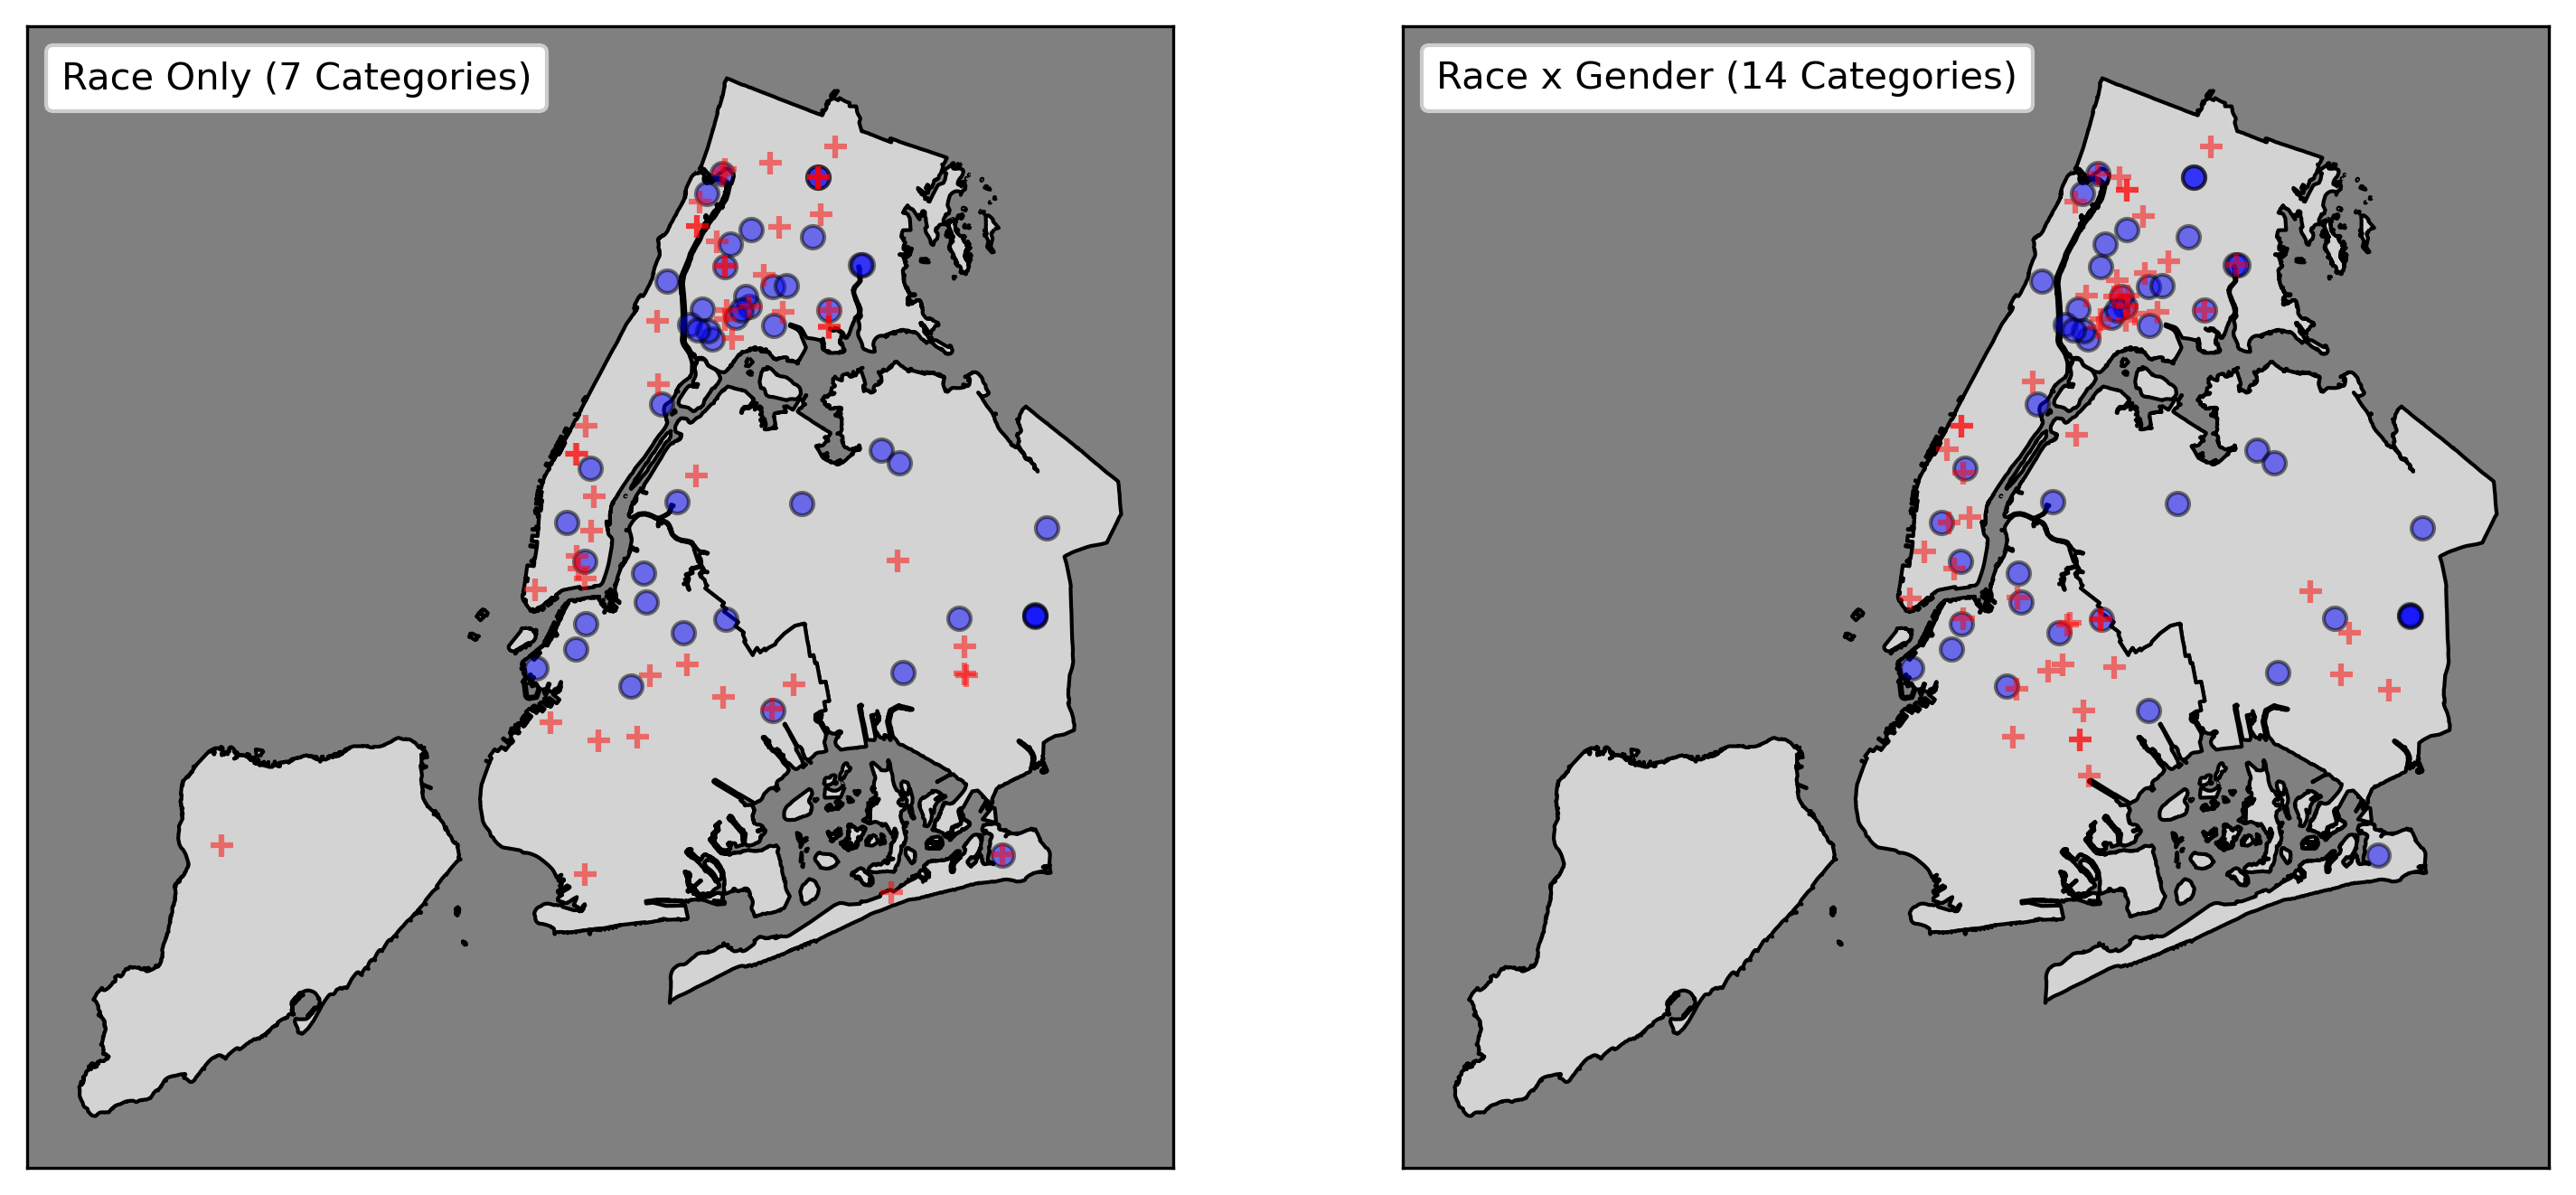

OSError: 'seaborn-colorblind' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [8]:
from geodatasets import get_path

school_df = pd.read_csv('features.csv')
race = ['n_A', 'n_B', 'n_C', 'n_D', 'n_E', 'n_F', 'n_G']
gen = ['n_male',   'n_female']
male = [r + '_m' for r in race]
female = [r + '_f' for r in race]
school_df['n_male'] = school_df[male].sum(axis=1)
school_df['n_female'] = school_df[female].sum(axis=1)
names = gen + race
renames = ['Male', 'Female'] + [s[2:] for s in race]
gen = ['Male', 'Female']
race = renames[2:]
for name, rename in zip(names, renames):
    school_df.columns = school_df.columns.str.replace(name, rename)
indices_7 = np.load('7_disagg_no_harm.npy')
indices_14 = np.load('14_disagg_no_harm.npy')
unique_to_7 = []
unique_to_14 = []
common_to_both = []
for i, (in_7, in_14) in enumerate(zip(indices_7, indices_14)):
    if in_7 and not in_14:
        unique_to_7.append(i)
    elif in_14 and not in_7:
        unique_to_14.append(i)
    elif in_7 and in_14:
        common_to_both.append(i)

unique_to_7 = school_df.iloc[unique_to_7]
unique_to_14 = school_df.iloc[unique_to_14]
common_to_both = school_df.iloc[common_to_both]

edgecolor = 'black'
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), dpi=dpi)
axes = axes.ravel()
axes[0].set_facecolor('gray')
axes[1].set_facecolor('gray')
boroughs = gpd.read_file(get_path("nybb"))
boroughs.to_crs("EPSG:4326").plot(ax=axes[0], color='lightgray', edgecolor='black')
boroughs.to_crs("EPSG:4326").plot(ax=axes[1], color='lightgray', edgecolor='black')

color = 'green'

x = common_to_both['longitude'].values
y = common_to_both['latitude'].values
axes[0].scatter(x, y, color='blue', edgecolor=edgecolor, alpha=0.5)
x = unique_to_7['longitude'].values
y = unique_to_7['latitude'].values
axes[0].scatter(x, y, color='red', edgecolor=edgecolor, alpha=0.5, marker='+')
axes[0].legend('', title='Race Only (7 Categories)', loc='upper left', facecolor='white', framealpha=1,
               labelspacing=0)
axes[0].set_xticks([])
axes[0].set_yticks([])

x = common_to_both['longitude'].values
y = common_to_both['latitude'].values
axes[1].scatter(x, y, color='blue', edgecolor=edgecolor, alpha=0.5)
x = unique_to_14['longitude'].values
y = unique_to_14['latitude'].values
axes[1].scatter(x, y, color='red', edgecolor=edgecolor, alpha=0.5, marker='+')
legend = axes[1].legend('', title='Race x Gender (14 Categories)', loc='upper left', facecolor='white', framealpha=1,
                        labelspacing=0)
axes[1].set_xticks([])
axes[1].set_yticks([])

plt.show()

with plt.style.context('seaborn-colorblind'):
    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, dpi=300, figsize=(6, 3))
    counts = unique_to_7[gen].sum(axis=0)
    freq_7 = counts.divide(counts.sum())
    counts = unique_to_14[gen].sum(axis=0)
    freq_14 = counts.divide(counts.sum())
    mf_df = pd.concat((freq_7, freq_14), axis=1)
    mf_df.columns = ['Race Only', 'Race x Gender']
    mf_df.plot.bar(ax=axes[0], rot=0, legend=False, color='gray', edgecolor='white')

    counts = unique_to_7[race].sum(axis=0)
    freq_7 = counts.divide(counts.sum())
    counts = unique_to_14[race].sum(axis=0)
    freq_14 = counts.divide(counts.sum())
    mf_df = pd.concat((freq_7, freq_14), axis=1)
    mf_df.columns = ['Race Only', 'Race x Gender']
    mf_df.plot.bar(ax=axes[1], rot=0, legend=False, color='gray', edgecolor='white')
    
    for ax in axes:
        for container, hatch in zip(ax.containers, (None, '//')):
            for patch in container.patches:
                patch.set_hatch(hatch)
                
    plt.rcParams['hatch.linewidth'] = 1

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), loc='center right', 
               bbox_to_anchor=(1.27, 0.5), title='Social Partition')
    plt.tight_layout()

def count_all_female(df):
    return (df['Male'] == 0).sum()

print(f'All female common to both: {count_all_female(common_to_both)}')
print(f'All female unique to 7: {count_all_female(unique_to_7)}')
print(f'All female unique to 14: {count_all_female(unique_to_14)}')